In [1]:
import os

import tensorflow as tf
import numpy as np

from tensorflow.python import keras # Important: TensorFlow-Optimization uses this version of Keras

# Need as one time command as Jupyter tries to set current Kernel as flag
tf.app.flags.DEFINE_string('f', '', 'kernel')
FLAGS = tf.app.flags.FLAGS



In [ ]:
# Tensorflow-models methods used to import sharded dataset
from imagenet_data import ImagenetData # Import this just to access certain flags
from image_processing import image_preprocessing

# THIS IS NOT BEING USED CURRENTLY, however if someone can figure out the issue with how 
# the tf records are being synthesized, this should theoretically work
def input_fn(subset):
    def parse_example_proto(example_serialized):
        """
        Parses an Example proto containing a training example of an image.

        Returns:
        image: Tensor tf.int32 containing the contents of a JPEG file.
        label: Tensor tf.int32 containing the label.
        """
        NUM_CLASSES = 1000 # Should be an input in the feature
        # Dense features in Example proto.
        feature_map = {
          'image/encoded': tf.FixedLenFeature([], dtype=tf.string,
                                              default_value=''),
          'image/class/label': tf.FixedLenFeature([1], dtype=tf.int64,
                                                  default_value=-1),
          'image/class/text': tf.FixedLenFeature([], dtype=tf.string,
                                                 default_value=''),
        }
        sparse_float32 = tf.VarLenFeature(dtype=tf.float32)
        
        # Sparse features in Example proto.
        feature_map.update(
          {k: sparse_float32 for k in ['image/object/bbox/xmin',
                                       'image/object/bbox/ymin',
                                       'image/object/bbox/xmax',
                                       'image/object/bbox/ymax']})

        features = tf.parse_single_example(example_serialized, feature_map)
        label = tf.reshape(tf.one_hot(tf.cast(features['image/class/label'], dtype=tf.int32), NUM_CLASSES), [NUM_CLASSES])
    
        xmin = tf.expand_dims(features['image/object/bbox/xmin'].values, 0)
        ymin = tf.expand_dims(features['image/object/bbox/ymin'].values, 0)
        xmax = tf.expand_dims(features['image/object/bbox/xmax'].values, 0)
        ymax = tf.expand_dims(features['image/object/bbox/ymax'].values, 0)

        # Note that we impose an ordering of (y, x) just to make life difficult.
        bbox = tf.concat(axis=0, values=[ymin, xmin, ymax, xmax])

        # Force the variable number of bounding boxes into the shape
        # [1, num_boxes, coords].
        bbox = tf.expand_dims(bbox, 0)
        bbox = tf.transpose(bbox, [0, 2, 1])

        image_buffer = features['image/encoded']
        return image_preprocessing(image_buffer, bbox, subset == 'train'), label

    
    tf_record_pattern = os.path.join(FLAGS.data_dir, '%s-*' % subset)
    files = tf.gfile.Glob(tf_record_pattern)

    filenames = tf.placeholder(tf.string, shape=[None])
    dataset = tf.data.TFRecordDataset(filenames=filenames)
    dataset = dataset.map(parse_example_proto)
    dataset = dataset.batch(FLAGS.batch_size)
    dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.repeat()
    
    iterator = dataset.make_initializable_iterator()
    next_batch = iterator.get_next()
    
    sess = keras.backend.get_session()
    sess.run(iterator.initializer, feed_dict={filenames: files})
    
    while True:
        inputs, labels = sess.run(next_batch)
        yield inputs, labels


In [ ]:
from tensorflow_model_optimization.sparsity import keras as sparsity
import re

EPOCHS = 20
NUM_TRAIN_SAMPLES = 1281167
NUM_VALIDATION_SAMPLES = 50000

# Initialization and Compilation
mobileNet = tf.keras.applications.MobileNet(weights=None) # Not ImageNet 2012 trained weights

end_step = np.ceil(1.0 * NUM_TRAIN_SAMPLES / FLAGS.batch_size).astype(np.int32) * EPOCHS

pruning_schedule = sparsity.PolynomialDecay(
                        initial_sparsity=0.0, final_sparsity=0.5,
                        begin_step=0, end_step=end_step, frequency=100)


pruned_model = tf.keras.Sequential()
for layer in mobileNet.layers:
    if(re.match(r"conv_pw_\d+$", layer.name)):
         pruned_model.add(sparsity.prune_low_magnitude(
            # Adding L1 regularizer to push weights closer to 0, 
            # allowing for more effective channel-wise pruning
#             tf.keras.layers.Conv2D(filters=layer.output_shape[-1], 
#                                    kernel_size=layer.kernel_size, 
#                                    kernel_regularizer=tf.keras.regularizers.l1(0.0001)),
            layer,
            pruning_schedule,
            block_size=(1, 1) # This is irrelevant, pruning is now channel wise
         ))
    else:
        pruned_model.add(layer)
        
opt = tf.train.AdamOptimizer()
pruned_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# Create checkpoint of best model
filepath = os.path.join(os.getcwd(), 'checkpoints/model.h5')
logdir = os.path.join(os.getcwd(), '__logs/')
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verblose=1, save_best_only=True, mode='max')
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=logdir, profile_batch=0)
update_step = sparsity.UpdatePruningStep()
pruning_summaries = sparsity.PruningSummaries(log_dir=logdir, profile_batch=0)

datagen = ImageDataGenerator(
        rescale=1./127.5,
        preprocessing_function=(lambda x: np.subtract(x, 1)),
        shear_range=0,
        zoom_range=0,
        horizontal_flip=False)

train_gen = datagen.flow_from_directory('/tf/workspace/imagenet/raw-data/train', (224,224))
validation_gen = datagen.flow_from_directory('/tf/workspace/imagenet/raw-data/validation', (224,224))

opt = tf.train.AdamOptimizer()
new_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the MobileNet model with its imagenet weights (faster convergence) and have it prune
pruned_model.fit_generator(
    generator=train_gen,
    validation_data=validation_gen,
    steps_per_epoch=NUM_TRAIN_SAMPLES // FLAGS.batch_size,
    validation_steps=NUM_VALIDATION_SAMPLES // FLAGS.batch_size,
    workers=0,
    verbose=1,
    epochs=EPOCHS,
    callbacks=[checkpoint, tensorboard, update_step, pruning_summaries]
)

In [ ]:
from keras.models import load_model

final_model = sparsity.strip_pruning(pruned_model)

final_model.save_weights('checkpoints/final_model_weights.h5')
final_model.load_weights('checkpoints/final_model_weights.h5', by_name=True)



In [ ]:
final_model = tf.keras.applications.MobileNet()
final_model.load_weights('checkpoints/final_model_weights.h5', by_name=True)

conv1_1/kernel:0 -- Total:864, Zeros: 0.00%
conv1_bn_1/gamma:0 -- Total:32, Zeros: 0.00%
conv1_bn_1/beta:0 -- Total:32, Zeros: 0.00%
conv1_bn_1/moving_mean:0 -- Total:32, Zeros: 0.00%
conv1_bn_1/moving_variance:0 -- Total:32, Zeros: 0.00%
conv_dw_1_1/depthwise_kernel:0 -- Total:288, Zeros: 0.00%
conv_dw_1_bn_1/gamma:0 -- Total:32, Zeros: 0.00%
conv_dw_1_bn_1/beta:0 -- Total:32, Zeros: 0.00%
conv_dw_1_bn_1/moving_mean:0 -- Total:32, Zeros: 0.00%
conv_dw_1_bn_1/moving_variance:0 -- Total:32, Zeros: 0.00%
conv_pw_1_1/kernel:0 -- Total:1024, Zeros: 0.00%
conv_pw_1_bn_1/gamma:0 -- Total:32, Zeros: 0.00%
conv_pw_1_bn_1/beta:0 -- Total:32, Zeros: 0.00%
conv_pw_1_bn_1/moving_mean:0 -- Total:32, Zeros: 0.00%
conv_pw_1_bn_1/moving_variance:0 -- Total:32, Zeros: 0.00%
conv_dw_2_1/depthwise_kernel:0 -- Total:288, Zeros: 0.00%
conv_dw_2_bn_1/gamma:0 -- Total:32, Zeros: 0.00%
conv_dw_2_bn_1/beta:0 -- Total:32, Zeros: 0.00%
conv_dw_2_bn_1/moving_mean:0 -- Total:32, Zeros: 0.00%
conv_dw_2_bn_1/moving_

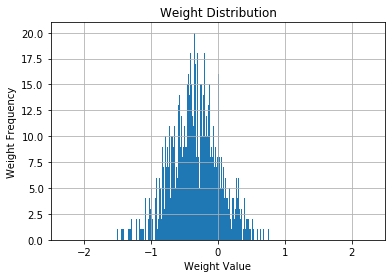

In [19]:
# Visualize weight distribution of Model 

from matplotlib import pyplot as plt
from functools import reduce

model = new_model

total_arr = []
for i, w in enumerate(model.get_weights()):
    print(
        "{} -- Total:{}, Zeros: {:.2f}%".format(
            model.weights[i].name, w.size, np.sum(w == 0) / w.size * 100
        )
    )
    total_arr += w.flatten().tolist()

total_arr = np.array(total_arr)

f = plt.figure(1)
plt.hist(w.flatten(), align='mid', histtype='barstacked', bins=200)
plt.ylabel('Weight Frequency')
plt.xlabel('Weight Value')
plt.title('Weight Distribution')
plt.xlim(-2.5, 2.5)
plt.grid(True)
f.show()

In [ ]:
# Channel wise pruned percentage
import re
for i, w in enumerate(model.get_weights()):
    print(model.weights[i].name, model.weights[i].shape)
    if re.match("conv_pw_\d+/kernel", model.weights[i].name):
        weights = np.transpose(w[0][0])
        pruned_channels = np.sum(weights == 0) / weights.shape[0]
        print(pruned_channels, weights.shape[0])
        

In [ ]:
# Freeze model 
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        gd = graph.as_graph_def()
                               
        if clear_devices:
            for node in gd.node:
                node.device = ""
                               
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, gd, output_names, freeze_var_names)
        return frozen_graph
    
keras.backend.set_learning_phase(0)

final_model = tf.keras.applications.MobileNet()
final_model.load_weights('checkpoints/final_model_weights.h5', by_name=True)
#final_model = tf.keras.models.load_model('checkpoints/new_surgery_model.hdf5')

sess = keras.backend.get_session()

saver = tf.train.Saver()
saver.save(sess, 'checkpoints/pruned_model.ckpt')

    
frozen_graph = freeze_session(sess, output_names=[output.op.name for output in final_model.outputs])

tf.io.write_graph(frozen_graph, 'checkpoints', 'frozen_surgery_model_50.pb', as_text=False)

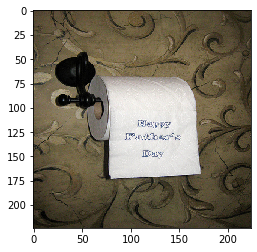

[[('n03777754', 'modem', 0.21626851), ('n04370456', 'sweatshirt', 0.17717431), ('n03709823', 'mailbag', 0.047656722), ('n03483316', 'hand_blower', 0.04136857), ('n04591713', 'wine_bottle', 0.037688356)]]


In [18]:
#new_model = tf.keras.models.load_model('checkpoints/surgery_model.hdf5')
model = new_model

# Manually calculate validation accuracy of Model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline
 
filename = '/tf/workspace/imagenet/raw-data/validation/n15075141/ILSVRC2012_val_00019558.JPEG'

# load an image in PIL format
original = load_img(filename, target_size=(224, 224))
plt.imshow(original)
plt.show()
 
# convert the PIL image to a numpy array
# IN PIL - image is in (width, height, channel)
# In Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)
 
# Convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# We want the input matrix to the network to be of the form (batchsize, height, width, channels)
# Thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)

processed_image = tf.keras.applications.mobilenet.preprocess_input(image_batch.copy())

prediction = model.predict(processed_image)
#print(np.where(prediction == np.amax(prediction)), np.amax(prediction))

print(decode_predictions(prediction))

In [ ]:
import tfkerassurgeon

model = final_model
surgeon = tfkerassurgeon.Surgeon(model)
        # i must be determined by iterating through weights of layer and figuring out which channels are zeroed
        # final_model = delete_channels(final_model, layer, [i])
for i, w in enumerate(model.get_weights()):
    if re.match("conv_pw_\d+/kernel", model.weights[i].name):
        weights = np.transpose(w[0][0])
        zero_channels = list(filter(lambda x: np.sum(weights[x]) == 0, range(weights.shape[0])))
        print(model.weights[i].name[:-9])
        surgeon.add_job('delete_channels', model.get_layer(name=model.weights[i].name[:-9]), channels=zero_channels)

new_model = surgeon.operate()
#print(new_model.summary())

In [ ]:
new_model.summary()

In [ ]:
# TF Keras Surgeon Test: Small Model
import tfkerassurgeon

small_model = tf.keras.Sequential()

small_model.add(tf.keras.layers.Conv2D(128, kernel_size=1, activation='relu', input_shape=(224,224,3)))
small_model.add(tf.keras.layers.BatchNormalization())
small_model.add(tf.keras.layers.MaxPool2D(pool_size=(8,8)))
small_model.add(tf.keras.layers.Conv2D(256, kernel_size=1, activation='relu'))
small_model.add(tf.keras.layers.BatchNormalization())
small_model.add(tf.keras.layers.MaxPool2D(pool_size=(8,8)))
small_model.add(tf.keras.layers.Conv2D(512, kernel_size=1, activation='relu'))
small_model.add(tf.keras.layers.Flatten())
small_model.add(tf.keras.layers.Dense(1000, activation='softmax'))


surgeon = tfkerassurgeon.Surgeon(small_model)

for layer in small_model.layers:
    print(layer.name)



surgeon.add_job('delete_channels', small_model.layers[0], channels=(list(range(20)) + [120, 121]))
surgeon.add_job('delete_channels', small_model.layers[3], channels=(list(range(20)) + [80, 22, 25]))

small_model.summary()

new_model = surgeon.operate()

new_model.summary()



